In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf 

import tf_agents as tfa

from kaggle_environments import evaluate, make
from kaggle_environments.envs.halite.helpers import *

from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.trajectories import time_step as ts

Loading environment football failed: No module named 'gfootball'


# Hyperparameters

In [2]:
num_iterations = 10000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 10  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

# Environment

In [3]:
class HaliteWrapper(py_environment.PyEnvironment):
    def __init__(self):
        
        # créer un environnement : où récupérer la config ? la renseigner directement ici ? 
        self._board_size = 7
        self._agent_count = 1
        self._max_turns = 20
        self._starting_halite = 2500
        self.env = make("halite", configuration={'episodeSteps':self._max_turns, 'size':self._board_size, 
                                                 'startingHalite':self._starting_halite})
        self.state = self.env.reset(num_agents=self._agent_count)
        
        self.obs = self.state[0].observation
        self.config = self.env.configuration
        self.max_cell_halite = self.config.maxCellHalite
        self.board = Board(self.obs, self.config)
                
        # observation_spec : va dépendre de la "vision" que l'on donne au vaisseau du plateau
        # action_spec 
#         self._channels = 2
        self._observation_spec = tfa.specs.BoundedArraySpec(
            shape=self.get_observation(self.board).shape, 
            dtype=np.int64, maximum=None, minimum=None)
        
        self._action_def = {0: None,
                            1: ShipAction.NORTH,
                            2: ShipAction.EAST,
                            3: ShipAction.SOUTH,
                            4: ShipAction.WEST,
#                             5: ShipAction.CONVERT
                           }
        self._action_spec = tfa.specs.BoundedArraySpec(shape=(), dtype=np.int32, maximum=len(self._action_def)-1, minimum=0)
        
        # définir des variables de suivi : compteur de tours, halite au tour précédent ... En fonction des besoins
        # ATTENTION : Le turn counter indique ici le numéro du tour qui sera lancé au prochain step, pas le numéro du dernier tour résolu 
        self.turn_counter = 1
        self.previous_cargo_halite = 0
    
    # Ajouter la position du vaisseau comme entrée ? 
    # Dans la fonction, ne pas utiliser self.board afin de pouvoir y faire appel en dehors de la classe
    #  plutôt à mettre dans un helper comme suggéré dans le post Kaggle
    def get_observation(self, board):
        size = board.configuration.size
        me = board.current_player

#         ships = np.zeros((1, size, size))
#         ship_cargo = np.zeros((1, size, size))
#         bases = np.zeros((1, size, size))

        # Possible de diviser par 1000 ou par max_halite afin d'avoir une valeur plus proche de 1
        halite = np.array(board.observation['halite']).reshape(1, size, size)
        halite = np.tile(halite, (3,3))
        
        # Reduce halite map to ship surroundings 
        ship = board.ships['0-1']
         # convert Halite SDK position format to np matrix 
        row = size - 1 - ship.position[1] + size
        col = ship.position[0] + size
        radius = 3 
        halite_radius = halite[0, row-radius+1:row+radius, col-radius+1:col+radius]
        
#         for iid, ship in board.ships.items():
#             # ATTENTION : Logique de me = board.current_player robuste ? 
#             ships[0, ship.position[1], ship.position[0]] = 1 if ship.player_id == me.id else -1
#             # Idem, possible de diviser le halite en cargo
#             ship_cargo[0, ship.position[1], ship.position[0]] = ship.halite

#         for iid, yard in board.shipyards.items():
#             bases[0, yard.position[1], yard.position[0]] = 1 if yard.player_id == me.id else -1
        
        # On pourra ajouter ships, ship_cargo et base 
        observation = np.concatenate([halite_radius], axis=0)
        observation = np.array(observation, dtype='int64')
        return observation
    
    def observation_spec(self):
        return self._observation_spec
    
    def action_spec(self):
        return self._action_spec
    
    def _reset(self):
        # créer un nouvel environnement 
        # board 
        self.env = make("halite", configuration={'episodeSteps':self._max_turns, 'size':self._board_size, 
                                                 'startingHalite':self._starting_halite})
        self.state = self.env.reset(num_agents=self._agent_count)
        
        self.obs = self.state[0].observation
        self.config = self.env.configuration
        self.max_cell_halite = self.config.maxCellHalite
        self.board = Board(self.obs, self.config)
        
        # réinitialiser TOUS les compteurs déclarés dans l'init 
        self.turn_counter = 1
        self.previous_cargo_halite = 0 
        
        # renvoyer le time_step initial 
        
        return_object = ts.restart(self.get_observation(self.board))
        
#         return_object = ts.restart(np.array(self.state_history, dtype=np.int32))
        
        return return_object
    
    def _step(self, action):
        
        # si le jeu est terminé, renvoyer reset() 
        if self.turn_counter > self._max_turns:
            return self._reset()
        
        # Prendre l'action et l'appliquer au plateau
        action = int(action) # nécessaire ? normalement on a déjà fixé que c'était un int 
        self.board.ships['0-1'].next_action = self._action_def[action]
        self.board = self.board.next()
        
        # Calculer le reward obtenu par l'action 
        reward = self.board.ships['0-1'].halite - self.previous_cargo_halite 
        
        # Update all counters 
        self.turn_counter += 1
        self.previous_cargo_halite = self.board.ships['0-1'].halite
        
        # prendre l'action, la transformer en int et l'appliquer au plateau 
        # board = board.next() : mettre à jour le plateau 
        # calculer le reward obtenu par l'action 
        # retourner la nouvelle observation 
        #  sous forme de time_step intermédiaire si le tour ne finit pas le jeu
        #  sous forme de time_step finale autrement 
        
        # final
        if self.turn_counter >= self._max_turns:
            return_object = ts.termination(self.get_observation(self.board), reward)
            return return_object
        else:
            return_object = ts.transition(self.get_observation(self.board), reward, discount=1.0)
            return return_object

In [4]:
# Pour tester le fonctionnement 
# train_py_env = HaliteWrapper()
# print(train_py_env.board)
# train_py_env._step(action=0)

In [5]:
train_py_env = HaliteWrapper()
eval_py_env = HaliteWrapper()

In [6]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [7]:
# Create a q_network based on the observation and action spec (ie, array shapes)
# For now, action will be a single command for a single ship 
from tf_agents.networks import q_network

fc_layer_params = (512,512)

q_net = q_network.QNetwork(
    input_tensor_spec=train_env.observation_spec(),
    action_spec=train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [8]:
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [9]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [10]:
from tf_agents.policies import random_tf_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [11]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [12]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

29.4

In [13]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

from tf_agents.trajectories import trajectory

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

dataset

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


<PrefetchDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 5, 5), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.int64, action=tf.int32, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [14]:
iterator = iter(dataset)

print(iterator)

In [15]:
#@test {"skip": true}
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 11441502.0
step = 400: loss = 102957328.0
step = 600: loss = 67968080.0
step = 800: loss = 49735984.0
step = 1000: loss = 10059871.0
step = 1000: Average Return = 0.20000000298023224
step = 1200: loss = 7197357.0
step = 1400: loss = 1267461.75
step = 1600: loss = 1181060.75
step = 1800: loss = 356858.6875
step = 2000: loss = 385472.0
step = 2000: Average Return = 2.0
step = 2200: loss = 396004.28125
step = 2400: loss = 214724.9375
step = 2600: loss = 104323.34375
step = 2800: loss = 18886.091796875
step = 3000: loss = 49315.5078125
step = 3000: Average Return = 0.0
step = 3200: loss = 110226.6171875
step = 3400: loss = 24770.689453125
step = 3600: loss = 24035.53515625
step = 3800: loss = 28633.802734375
step = 4000: loss = 40346.5703125
step = 4000: Average Return = 44.79999923706055
step = 4200: loss = 17348.2265625
step = 4400: loss = 14877.9404296875
step = 4600: loss = 18832.1875
step = 4800: loss = 3771.502685546875
step = 5000: loss = 18579.49609375
step = 500

(-14.435000610351564, 250.0)

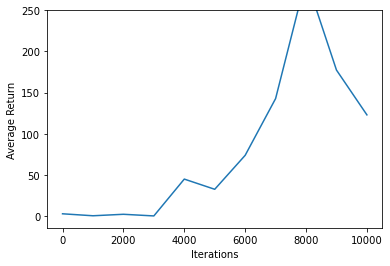

In [16]:
#@test {"skip": true}
import matplotlib.pyplot as plt

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [85]:
time_step = eval_env.reset()
print(eval_py_env.board)

while not time_step.is_last():
    action_step = eval_policy.action(time_step)
    print(eval_py_env._action_def[int(action_step.action)])
    time_step = eval_env.step(action_step.action)
    print(eval_py_env.board)

| 0 | 0 | 0 | 1 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 3 | 0 | 0 |a5 | 0 | 0 | 3 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 1 | 0 | 0 | 0 |

None
| 0 | 0 | 0 | 1 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 3 | 0 | 0 |a3 | 0 | 0 | 3 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 1 | 0 | 0 | 0 |

None
| 0 | 0 | 0 | 1 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 3 | 0 | 0 |a2 | 0 | 0 | 3 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 1 | 0 | 0 | 0 |

None
| 0 | 0 | 0 | 1 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 3 | 0 | 0 |a2 | 0 | 0 | 3 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 1 | 0 | 0 | 0 |

None
| 0 | 0 | 0 | 1 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 3 | 0 | 0 |a1 | 0 | 0 | 3 |
| 0 | 0 | 0 | 0 

In [299]:
# Agent 

def time_step_ok(time_step_nok):
    tensors = []
    for array in time_step_nok:
        new_array = np.expand_dims(array, axis=0)
        tensor = tf.constant(new_array)
        tensors.append(tensor)
        
    # step_type
    # reward
    # discount
    # observation
    
    return ts.TimeStep(tensors[0], tensors[1], tensors[2], tensors[3])

def my_rl_agent(obs, config):
    board = Board(obs, config)
    train_py_env.get_observation(board)
    me = board.current_player
    
    if obs.step == 0:
        time_step = ts.restart(train_py_env.get_observation(board))
    elif obs.step >= config.episodeSteps-1:
        time_step = ts.termination(train_py_env.get_observation(board), reward=0)
    else:
        time_step = ts.transition(train_py_env.get_observation(board), reward=0)
    
    time_step = time_step_ok(time_step)
    
    action_int = int(eval_policy.action(time_step).action)
    action = train_py_env._action_def[action_int]
    
    for ship in me.ships:
        ship.next_action = action

    return me.next_actions

In [306]:
train_py_env._reset()
env = train_py_env.env

In [321]:
train_py_env._reset()
env = train_py_env.env
env.run([my_rl_agent])
env.render(mode='ipython', width=400, height=300)

In [11]:
steps = train_py_env.env.run(['random', 'random'])

In [ ]:
# possible de faire un step sur l'environnement Kaggle 
env.step(actions={'0-1': 'NORTH'})

In [29]:
# Pour obtenir l'id du joueur actuel
obs.player

0

In [ ]:
# Possible de définir un agent qui prend en entrée un board plutot que obs et config
# On voit qu'on peut aussi fournir à l'environnement Kaggle l'agent sous forme de fonction plutôt que de fichier 

@board_agent
def move_ships_north_agent(board):
    for ship in board.current_player.ships:
        ship.next_action = ShipAction.NORTH

env.reset(2)
env.run([move_ships_north_agent, "random"])
env.render(mode="ipython", width=500, height=450)